In [1]:
import numpy as np
import astropy.io.fits as fits
import fitsio
import healpy as hp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
condFile = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/exptime_teff/y3a2_g_o.4096_t.32768_EXPTIME.SUM_EQU.fits.gz'
healMap = hp.fitsfunc.read_map(condFile, nest = True)
healMap[healMap==-1.6375e+30]=hp.UNSEEN
condSigExt=hp.ud_grade(healMap,2048)

In [3]:
goldFile1 = '/hdfs/bechtol/balrog/y3/y3_gold_2_2_DES0129-5248.fits'
goldFile2 = '/hdfs/bechtol/balrog/y3/y3_gold_2_2_DES0245-0207.fits'
goldFile3 = '/hdfs/bechtol/balrog/y3/y3_gold_2_2_DES0350-2415.fits'
goldFile4 = '/hdfs/bechtol/balrog/y3/y3_gold_2_2_DES0457-3206.fits'
goldFile5 = '/hdfs/bechtol/balrog/y3/y3_gold_2_2_DES2259+0001.fits'

In [4]:
goldData1 = fitsio.read(goldFile1, columns = ['RA', 'DEC', 'EXTENDED_CLASS_SOF'])
goldData2 = fitsio.read(goldFile2, columns = ['RA', 'DEC', 'EXTENDED_CLASS_SOF'])
goldData3 = fitsio.read(goldFile3, columns = ['RA', 'DEC', 'EXTENDED_CLASS_SOF'])
goldData4 = fitsio.read(goldFile4, columns = ['RA', 'DEC', 'EXTENDED_CLASS_SOF'])
goldData5 = fitsio.read(goldFile5, columns = ['RA', 'DEC', 'EXTENDED_CLASS_SOF'])

In [5]:
RA = np.concatenate((goldData1['RA'], goldData2['RA'], goldData3['RA'], goldData4['RA'], goldData5['RA']))
DEC = np.concatenate((goldData1['DEC'], goldData2['DEC'], goldData3['DEC'], goldData4['DEC'], goldData5['DEC']))
CLASS = np.concatenate((goldData1['EXTENDED_CLASS_SOF'], goldData2['EXTENDED_CLASS_SOF'], goldData3['EXTENDED_CLASS_SOF'], goldData4['EXTENDED_CLASS_SOF'], goldData5['EXTENDED_CLASS_SOF']))

cutIndices = np.where(CLASS >= 0)[0]

RA = RA[cutIndices]
DEC = DEC[cutIndices]

In [6]:
fracFile = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/fracdet/y3a2_i_o.4096_t.32768_frac_EQU.fits.gz'
fracMap = hp.fitsfunc.read_map(fracFile, nest = True)
fracMap[fracMap==-1.6375e+30]=hp.UNSEEN
fracDetExt = hp.ud_grade(fracMap,2048)

In [7]:
goldPixels = hp.ang2pix(2048, RA, DEC, lonlat = True, nest = True)

In [8]:
validPixels1 = np.full(12*(2048**2), False, dtype = bool)
validPixels2 = np.full(12*(2048**2), False, dtype = bool)
validPixels3 = np.full(12*(2048**2), False, dtype = bool)
validPixels1[np.where(condSigExt >= 0)[0]] = True
validPixels2[np.where(fracDetExt >= 0)[0]] = True
validPixels3[goldPixels] = True

validPixels = validPixels1 & validPixels2 & validPixels3

In [9]:
goldIndices = np.where(validPixels[goldPixels])[0]

In [10]:
condSig = condSigExt[validPixels]
fracDet = fracDetExt[validPixels]
condPix = np.where(validPixels)[0]
goldPix = goldPixels[goldIndices]
goldDetTemp = np.ones_like(goldPix)

sortInds = goldPix.argsort()
goldPix = goldPix[sortInds[::1]]

In [11]:
condInd = 0
goldInd = 0
goldDet = np.zeros_like(condPix)

while goldInd < len(goldPix):
    if condPix[condInd] == goldPix[goldInd]:
        goldDet[condInd] += goldDetTemp[goldInd]
        goldInd += 1
    else:
        condInd += 1

In [12]:
aveDens = np.sum(goldDet) / np.sum(fracDet)

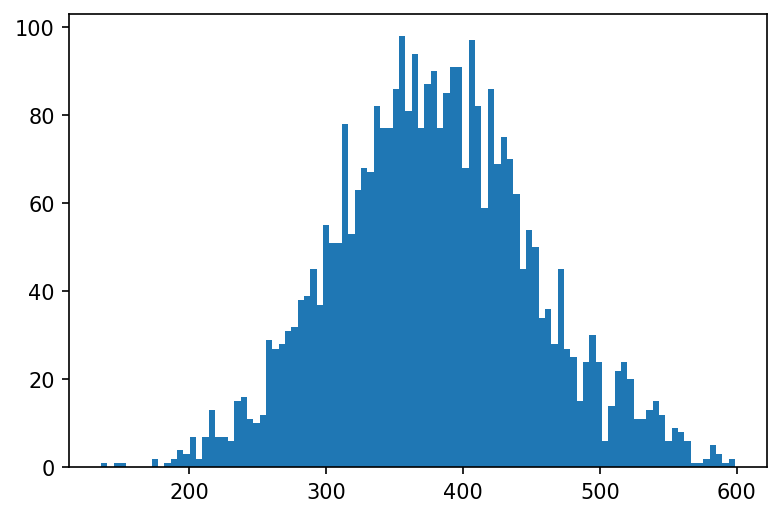

In [13]:
plt.figure(dpi = 150)
plt.hist(condSig, bins = 100)
plt.show()

In [14]:
condMin = 100
condMax = 600
numBins = 25

In [15]:
xValues = np.linspace(condMin, condMax, numBins, endpoint = False) + (condMax - condMin) / (2 * numBins)

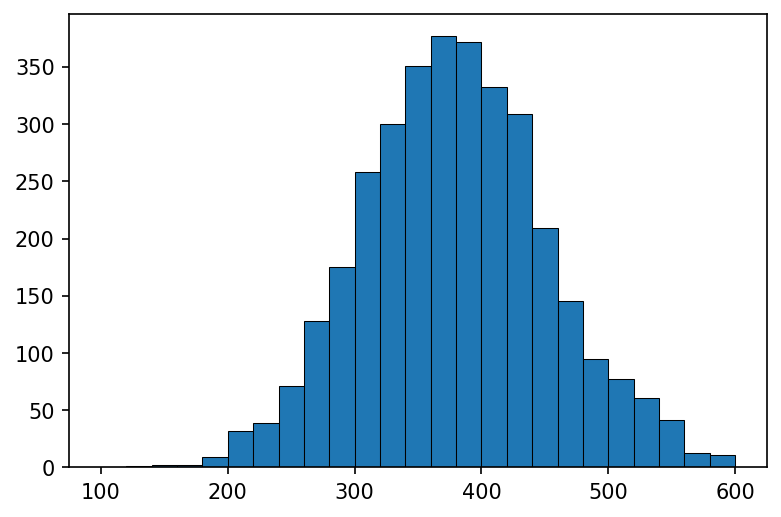

In [16]:
plt.figure(dpi = 150)
plt.hist(condSig, bins = np.linspace(condMin, condMax, numBins + 1), edgecolor='black', linewidth=.5)
plt.show()

In [17]:
def binIndicesByCondition(cond, condMin, condMax, numBins):
    binBounds = np.linspace(condMin, condMax, (numBins + 1), endpoint = True)
    indByBin = []
    for i in range(len(binBounds) - 1):
        validIndices = np.array(np.where((cond >= binBounds[i]) & (cond < binBounds[i + 1]))[0])
        indByBin.append(validIndices)
    return np.array(indByBin, dtype = object)

In [18]:
binInd = binIndicesByCondition(condSig, condMin, condMax, numBins)

In [19]:
percentBins = []
goldBins = []
for i in range(len(binInd)):
    goldBins.append(np.sum(goldDet[binInd[i]]))
    totalGold = np.sum(goldDet[binInd[i]])
    percentBins.append(totalGold / np.sum(fracDet[binInd[i]]))

goldBins = np.array(goldBins)
realPerBins = np.array(percentBins) / aveDens

/tmp/ipykernel_2035040/589138820.py:6: RuntimeWarning: invalid value encountered in true_divide
  percentBins.append(totalGold / np.sum(fracDet[binInd[i]]))


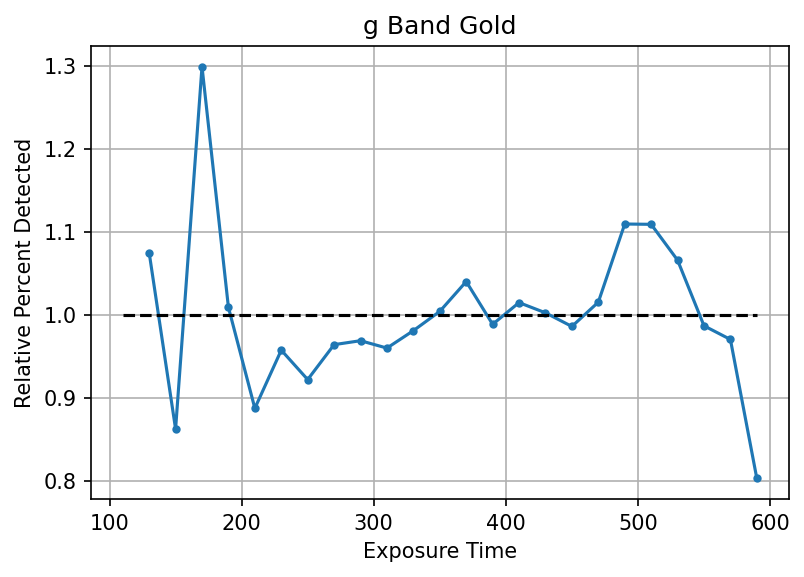

In [22]:
plt.figure(dpi = 150)
plt.plot(xValues, realPerBins, marker = '.')
plt.plot(xValues, np.ones_like(xValues), color = 'k', linestyle = '--')
# plt.ylim([0.6, 1.3])
plt.title('g Band Gold')
plt.ylabel('Relative Percent Detected')
plt.xlabel('Exposure Time')
plt.grid()
plt.show()

In [23]:
len(RA)

182879